In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

sns.set_style("whitegrid")

# Сравнение моделей

## Теория вопроса

### Проверка апостериорного распределения



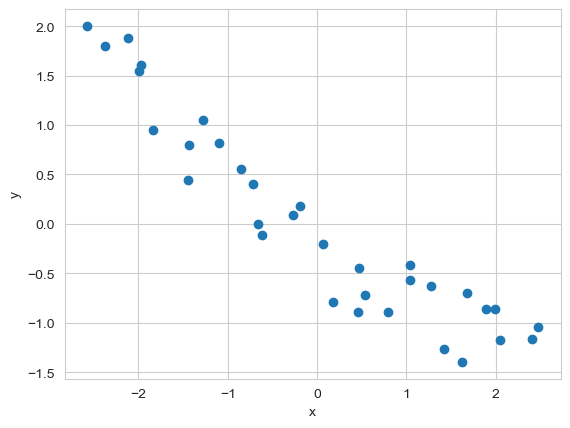

In [2]:
dummy_data = np.loadtxt('dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))

x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()

plt.scatter(x_1s[0], y_1s)
plt.xlabel('x');
plt.ylabel('y');


In [3]:
with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + β * x_1s[0]

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_1s)

    trace_l = pm.sample(2000, chains=4)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = α + pm.math.dot(β, x_1s)

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_1s)

    trace_p = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [α, β, ϵ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


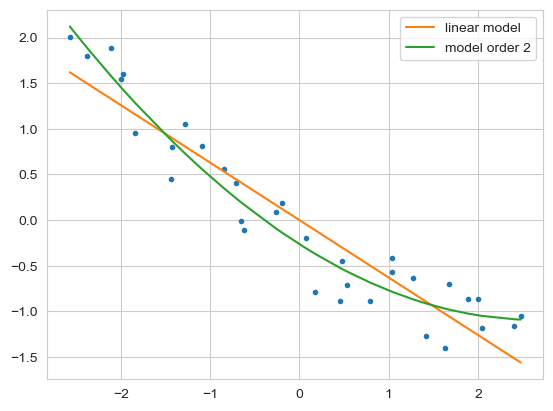

In [4]:
chain_l = trace_l.posterior.stack(samples=("chain", "draw"))
chain_p = trace_p.posterior.stack(samples=("chain", "draw")) 

x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)

α_l_post = chain_l['α'].mean().values
β_l_post = chain_l['β'].mean().values
y_l_post = α_l_post + β_l_post *  x_new

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = chain_p['α'].mean().values
β_p_post = chain_p['β'].mean(axis=1).values
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')


plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend();

In [5]:
pm.sample_posterior_predictive(trace_l, model=model_l, extend_inferencedata=True)
pm.sample_posterior_predictive(trace_p, model=model_p, extend_inferencedata=True)

y_l = trace_l.posterior_predictive['y_pred']
y_p = trace_p.posterior_predictive['y_pred']

Sampling: [y_pred]


Sampling: [y_pred]


([], [])

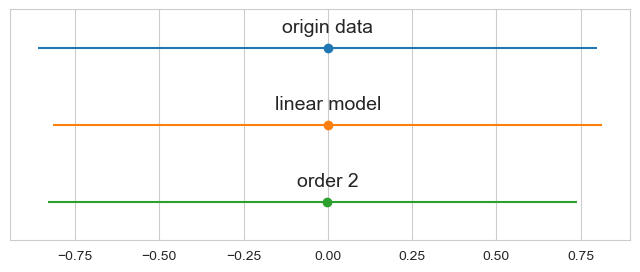

In [6]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['origin data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

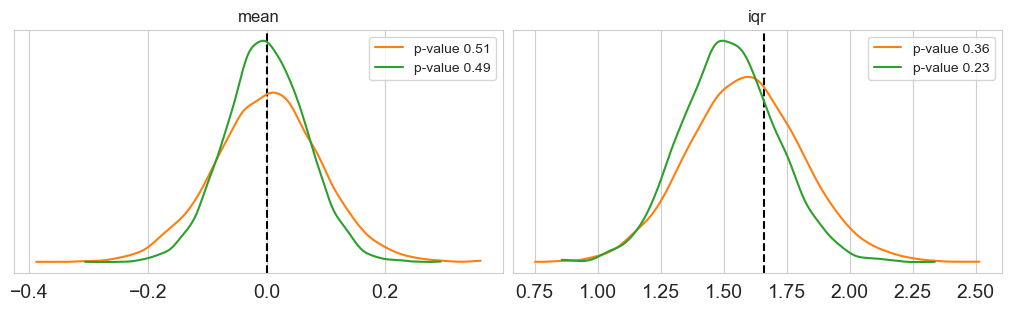

In [7]:

fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

# МАГИЧЕСКАЯ команда распаковки кортежа для его распаковки и передачи вычисления
def iqr(x, axis=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis)) 

y_l_chain = y_l.stack(samples=('chain', 'draw')).values.T
y_p_chain = y_p.stack(samples=('chain', 'draw')).values.T

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    for d_sim, c in zip([y_l_chain, y_p_chain], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c},
                    label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()

Байесовский p-value это вероятность получения имитационной статистической характеристики $T_{sim}$, большей или равной, чем статистическая характеристика реальных данных $T_{obs}$. Здесь $T$ может быть практически любой характеристикой, которая предоставляет возможность получения обобщенного результата по исследуемым данным.

На схеме указаны среднее значение на левой диаграмме и стандартное отклонение на правой диаграмме. 

Характеристика T должна выбираться с учетом ответа на вопрос, который стал главной побудительной причиной выполнения статистического вывода.

Рассматриваемые здесь p-value являются байесовскими, потому что для распределения сэмплирования (выборки) мы используем прогнозируемое апостериорное распределение. Также отметим, что здесь мы не принимаем во внимание какие-либо нулевые гипотезы (предположения), фактически мы имеем полное апостериорное распределение для $\theta$ и рассматриваем только условия, связанные с наблюдаемыми реальными данными. 

Еще одно отличие состоит в том, что мы не используем какое-либо предварительно определенное пороговое значение для объявления статистической значимости, а кроме того, не проводим проверки гипотез – мы лишь пытаемся найти числовое значение для оценки соответствия прогнозируемого апостериорного распределения наблюдаемому исходному набору данных.

### Информационные критерии

Информационные критерии – это набор различных, иногда взаимосвязанных инструментальных средств, которые используются для сравнения моделей в отношении того, насколько точно они соответствуют конкретным данным, при этом сложность моделей учитывается через штрафные факторы. 

Нам необходим надежный способ достижения баланса между степенью точности объяснения данных моделью, с одной стороны, и степенью сложности модели – с другой.

На данный момент самыми наиболее пчасто применимыми критериями являются:
* WAIC (widely applicable information criterion or Watanabe-Aikake information criterion) информационный критерий Ватанабе–Аикаке
* LOO (LOOCV) - Парето-сглаженная выборка по значимости для перекрестной проверки. При перекрестной проверке данные многократно разделяются на тренировочный и тестовый набор, итеративно подбирая модель и оценивая соответствие с тестовыми данными.

Мы не будем подробно останавливаться на данных критериях, однако отметич, что они "делают": 
* WAIC содержит два элемента: первый измеряет степень соответствия данных и модели, второй – штрафует сложные модели
* основная идея заключается в возможности аппроксимации LOOCV при помощи соответствующего перерасчета весовых коэффициентов правдоподоби. Проблема заключается в том, что результаты нестабильны. Для устранения нестабильности был введен новый метод с применением подхода, названного парето-сглаженной выборкой по значимости для перекрестной проверки LOOCV (Pareto-smoothed importance sampling – PSIS), который может применяться для вычисления более надежных оценок LOOCV. Интерпретация этого метода похожа на интерпретацию критерия WAIC: чем меньше значение, тем выше оцениваемая прогнозируемая точность рассматриваемой модели. 

Таким образом, наиболее предпочтительны модели с более низкими значениями.

## Простой пример

Оценка эффективности тренинга по подготовке к сдаче экзамена SAT (отдаленный аналог ЕГЭ) в 8 американских школах. $y$ - эффект от подготовки к экзамену (средний по школе), и стандартное отклонение sigma. 
Расмотрим две модели:
* стандартную модель с единым фиксированным эффектом от тренингов:
* иерархическую модель, которая лишь частично объединяет данные, допуская существования для каждых собственных случайных эфектов.

In [8]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

In [9]:
with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sigma=1e6)
    obs = pm.Normal('obs', mu, sigma=sigma, observed=y)
    trace_p = pm.sample(2000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.


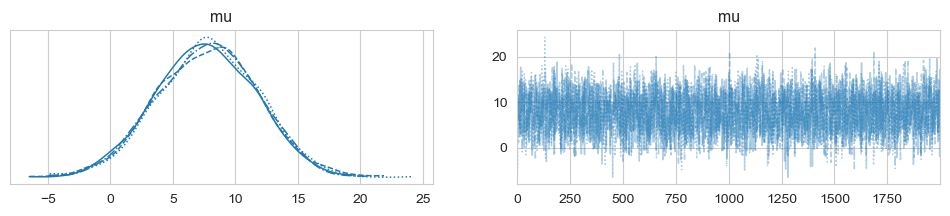

In [10]:
az.plot_trace(trace_p);

In [11]:
with pm.Model() as hierarchical:
    eta = pm.Normal('eta', 0, 1, shape=J)
    tau = pm.HalfCauchy('tau', 5)
    mu = pm.Normal('mu', 0, sigma=1e6)
    theta = pm.Deterministic('theta', mu + tau*eta)
    obs = pm.Normal('obs', theta, sigma=sigma, observed=y)
    trace_h = pm.sample(2000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [eta, tau, mu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


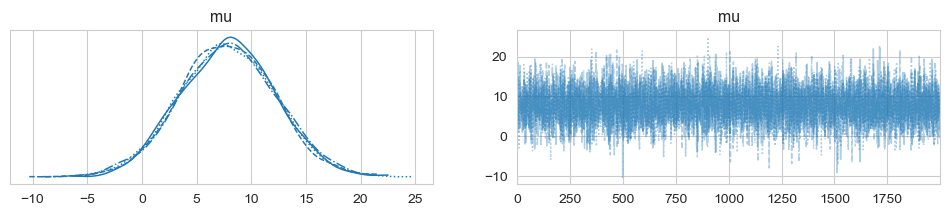

In [12]:
az.plot_trace(trace_h, var_names=['mu']);

In [13]:
display(az.summary(trace_p,var_names=['mu']))
display(az.summary(trace_h,var_names=['mu']))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,7.757,3.99,0.436,15.207,0.066,0.047,3668.0,5627.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,7.832,4.401,-0.572,15.902,0.046,0.035,9219.0,5736.0,1.0


In [14]:
pm.compute_log_likelihood(trace_p, model=pooled)
trace_p

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [15]:
pm.compute_log_likelihood(trace_h, model=hierarchical)
trace_h

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [16]:
pooled_loo = az.loo(trace_p)
pooled_loo

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -30.52     1.10
p_loo        0.64        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [17]:
pooled_waic = az.waic(trace_p)
pooled_waic

Computed from 8000 posterior samples and 8 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -30.50     1.10
p_waic        0.63        -

In [18]:
hierarchical_loo = az.loo(trace_h)
hierarchical_waic = az.waic(trace_h)

In [19]:
diff_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
diff_loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
pooled,0,-30.515431,0.637713,0.00000,1.000000e+00,1.099215,0.000000,False,log
hierarchical,1,-30.758171,1.053343,0.24274,2.220446e-16,0.994919,0.119124,False,log


In [20]:
diff_waic = az.compare({"hierarchical": trace_h, "pooled": trace_p}, ic = 'waic')

Результат сравнения:
* rank - ранг модели, лучшая имеет ранг 0
* elpd_loo/waic - содержит значения LOO/WAIC в масштабе указанном в последнем столбце `scale`. DataFrame всегда сортируется от лучшего LOO/WAIC к худшему.
* p_loo/waic - оценка эффективного количества параметров (но не принимайте это значение как истину в последней инстанции!!!). 
* d_waic – относительная разность между значением LOO/WAIC для модели с наивысшей оценкой и значениями WAIC для каждой последующей модели. Поэтому для первой модели в этом столбце всегда находится значение 0.
* weight. Иногда при сравнении моделей не требуется выбирать самую лучшую модель. Вместо этого необходимы прогнозы по усредненным характеристикам всех моделей (или нескольких моделей). В идеальном варианте желательно получить взвешенное среднее арифметическое с приданием большего веса той модели, которая, как предполагается, лучше объясняет/прогнозирует данные. Для выполнения этой задачи применяются различные методы. Один из них – весовые коэффициенты Акаике на основе значений LOO/WAIC для каждой модели. 
Эти веса могут быть  интерпретированы как вероятность истинности каждой модели (среди сравниваемых моделей) с учетом данных.
* se - значения стандартной ошибки при вычислениях LOO/WAIC. Стандартная ошибка может оказаться полезной для установления неопределенности оценок LOO/WAIC.
* dse - стандартая ошибкa разностей между двумя значениями WAIC. Для модели с наивысшей оценкой это значение всегда равно 0.
* waring - значение True сообщает, что вычисление LOO/WAIC, возможно, является ненадежным.
* waic_scale - масштаб (тип) отображения WAIC. Варианты - log : (по умолчанию, больший лучше) логарифмический; negative_log : -1 * логарифмический(меньший лучше); deviance : -2 * логарифмический (меньший лучше). 

Практически ту же самую информацию можно получить в наглядном графическом виде с помощью функции <code>az.plot_compare</code>. Эта вторая полезная вспомогательная функция принимает вывод функции <code>az.compare</code> и формирует сводную диаграмму в стиле, используемом в книге Ричарда МакЭлрайта (Richard McElreath) Statistical Rethinking:

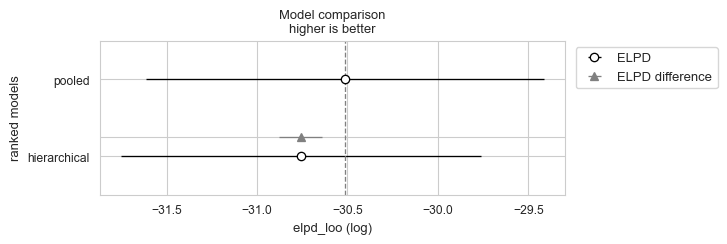

In [21]:
az.plot_compare(diff_loo);

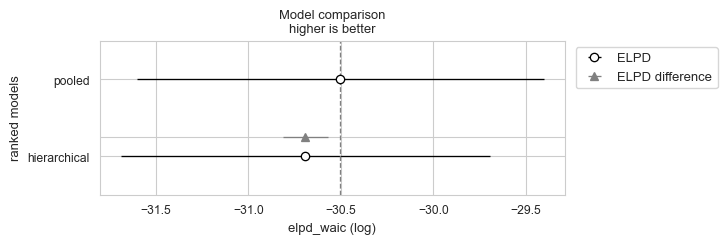

In [22]:
az.plot_compare(diff_waic);

Диаграмма требует более подробного описания:
* незакрашенный (пустой) кружок представляет значения LOO/WAIC, а черные
полоски ошибоки, связанные с ним (значения стандартного отклонения LOO/WAIC);
* наименьшее значение LOO/WAIC изображено вертикальной штриховой серой линией для упрощения сравнения с другими значениями LOO/WAIC;
* для всех моделей, за исключением модели с наивысшей оценкой, также показан значок треугольника, отображающий значение разности LOO/WAIC между рассматриваемой моделью и наилучшей моделью, а серая полоска ошибок, связанная с этим значком, – это стандартная ошибка разностей между LOO/WAIC с наивысшей оценкой и значением LOO/WAIC для каждой модели.

Простейший способ использования информационных критериев – выполнение процедуры выбора модели. Нужно просто выбрать модель с наименьшим значением информационного критерия и забыть обо всех прочих моделях. 

В такой интерпретации для рассматриваемого выше примера это очень простой выбор – первая модель самая лучшая.

## Выбор одной из трех моделей

Краткое описание модели:
мы хотим исследовать состав молока у нескольких видов приматов, предполагается, что самки приматов с большим мозгом производят более питательное молоко (в общем, это предположение исходит из того, что развития большего объема мозга требуется более калорийное молоко). 

Это важный вопрос для эволючионного развития, и мы попытаемся дать и ответить на него. 

Мы будем использовать 3 переменные, две прогнозирующие переменные: доля неокортекса по сравнению с общей массой мозга (отвечает за высшие нервные функции, например речь) и  массы тела самки, а для прогнозируемой переменной, килокалорий на грамм молока. 

С этими переменными мы собираемся построить 3 различные линейные модели:

* Модель, использующая только процент неокортекса в коре головного мозга
* Модель, использующая только массу тела
* Модель с использованием обеих переменных

In [31]:

d = pd.read_csv('milk.csv', sep =';')
d = d[["kcal.per.g", "neocortex.perc", "mass"]].rename({"neocortex.perc": "neocortex"}, axis=1)
#d["log_mass"] = np.log(d["mass"])
d = d[~d.isna().any(axis=1)]#.drop("mass", axis=1)
d.iloc[:, 1:] = d.iloc[:, 1:] - d.iloc[:, 1:].mean()
display(d.head())
display(d.tail())

,kcal.per.g,neocortex,mass
0,0.49,-12.415882,-14.687647
5,0.47,-3.035882,-11.387647
6,0.56,-3.035882,-11.267647
7,0.89,0.064118,-14.127647
9,0.92,1.274118,-15.957647


,kcal.per.g,neocortex,mass
23,0.54,3.684118,18.842353
24,0.49,5.024118,62.792353
26,0.48,2.664118,24.102353
27,0.55,8.724118,16.472353
28,0.71,7.914118,38.312353


### Модель 0: только `neocortex`.

In [32]:
with pm.Model() as model_0:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + beta * d["neocortex"]

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])
    trace_0 = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood": True})
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


### Модель 1: только калорийность.

In [34]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + beta * d["mass"]

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    trace_1 = pm.sample(2000, chains=4, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


### Модель 2: и то и то

In [35]:
with pm.Model() as model_2:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal("sigma", 10)

    mu = alpha + pm.math.dot(beta, d[["neocortex", "mass"]].T)

    kcal = pm.Normal("kcal", mu=mu, sigma=sigma, observed=d["kcal.per.g"])

    trace_2 = pm.sample(2000, chains=4,  idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


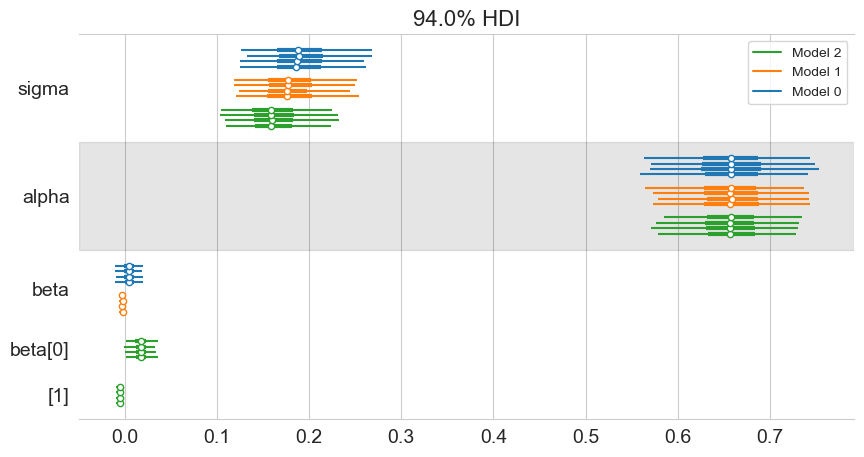

In [36]:
traces = [trace_0, trace_1, trace_2]
az.plot_forest(traces, figsize=(10, 5));

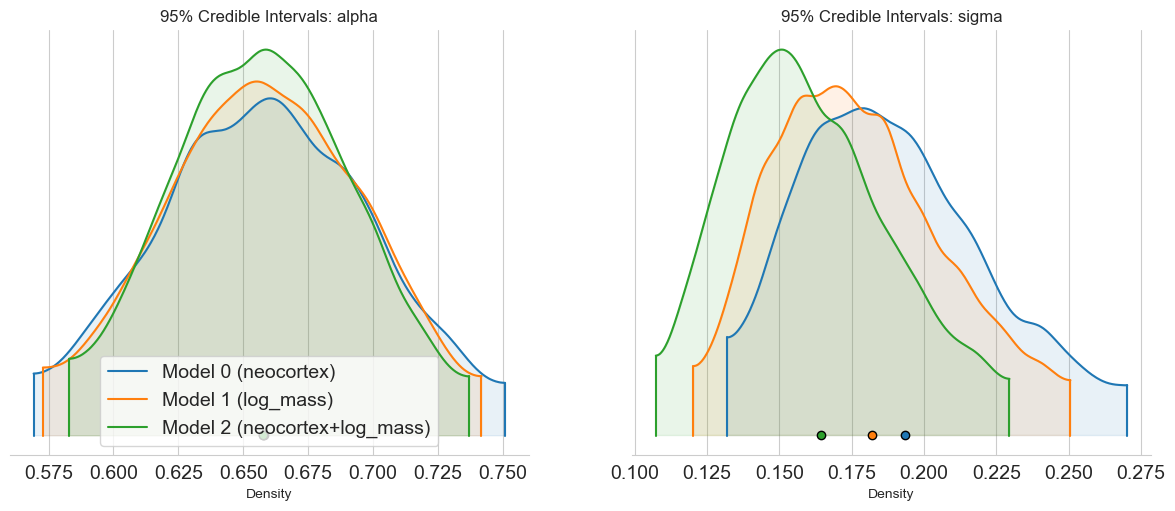

In [37]:
ax = az.plot_density(
    traces,
    var_names=["alpha", "sigma"],
    shade=0.1,
    data_labels=["Model 0 (neocortex)", "Model 1 (log_mass)", "Model 2 (neocortex+log_mass)"],
)

ax[0, 0].set_xlabel("Density")
ax[0, 0].set_ylabel("")
ax[0, 0].set_title("95% Credible Intervals: alpha")

ax[0, 1].set_xlabel("Density")
ax[0, 1].set_ylabel("")
ax[0, 1].set_title("95% Credible Intervals: sigma");

In [43]:
model_dict = dict(zip(["model_0", "model_1", "model_2"], traces))
comp = az.compare(model_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2,0,5.898608,2.726007,0.000000,0.942222,1.293317,0.000000,False,log
model_1,1,4.616775,1.885151,1.281833,0.057778,1.702268,1.646849,False,log
model_0,2,3.606447,1.925622,2.292161,0.000000,1.565514,1.330353,False,log


Мы можем видеть, что лучшая модель - модель_2, модель с двумя переменными. Обратите внимание, что DataFrame упорядочен от меньшего к большему (т.е. от лучшей к худшей модели).

Мы также можем увидеть, что мы получаем столбец с относительным весом (`weight`) для каждой модели. Этот вес можно приблезительно интерпретировать, как с вероятностью с которой модель сделает правильные прогнозы на будущих данных. 

Конечно, эта интерпретация зависит от моделей, используемых для вычисления весовых коэффициентов, если мы добавим или удалим модели, то `weight` будет меняться. А также зависит от предположений, лежащих в основе выбранного информационного критерия. Поэтому постарайтесь не переоценивать эти значения.

Теперь мы будем использовать совокупные веса для генерации прогнозов, основанных не на одной модели, а на взвешенном наборе моделей. 

Это один из способов усреднения модели. Используя PyMC, мы можем вызвать функцию `sample_posterior_predictive_w` следующим образом:

In [41]:
# важно дописать extend_inferencedata=True - довложить апостериорное предсказание
pm.sample_posterior_predictive(trace=trace_0, model=model_0, extend_inferencedata=True);
pm.sample_posterior_predictive(trace=trace_1, model=model_1, extend_inferencedata=True);
ppc_2 = pm.sample_posterior_predictive(trace=trace_2, model=model_2, extend_inferencedata=True);


Sampling: [kcal]


Sampling: [kcal]


Sampling: [kcal]


In [45]:
model_dict = dict(zip(["model_0", "model_1", "model_2"], traces))
comp = az.compare(model_dict)
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2,0,5.898608,2.726007,0.000000,0.942222,1.293317,0.000000,False,log
model_1,1,4.616775,1.885151,1.281833,0.057778,1.702268,1.646849,False,log
model_0,2,3.606447,1.925622,2.292161,0.000000,1.565514,1.330353,False,log


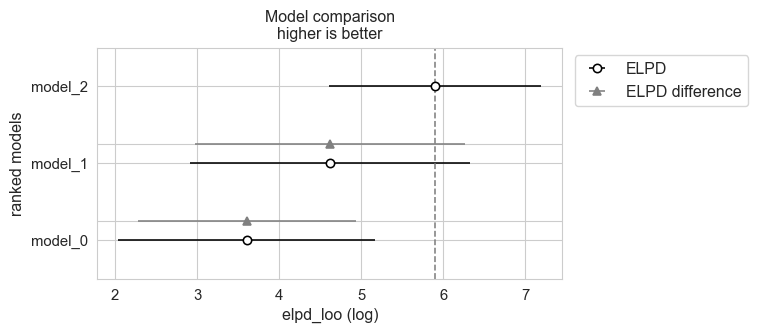

In [46]:
az.plot_compare(comp);

In [47]:
ppc_w = az.weight_predictions(traces, weights=comp.weight.sort_index().values)
ppc_w

Inference data with groups:
	> posterior_predictive
	> observed_data

In [21]:
ppc_w_mean = ppc_w.posterior_predictive['kcal'].mean(axis=1)
ppc_w_mean

<xarray.DataArray 'kcal' (kcal_dim_2: 17)>
array([0.39179903, 0.55705555, 0.55726297, 0.71497152, 0.87452495,
       0.76272984, 0.71175282, 0.71047719, 0.82691045, 0.76666904,
       0.72446843, 0.63790918, 0.56274331, 0.52105901, 0.52248332,
       0.70880481, 0.63874963])
Coordinates:
  * kcal_dim_2  (kcal_dim_2) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

In [18]:
ppc_2.posterior_predictive['kcal'].mean(axis=1).shape

(4, 17)

In [117]:
neocortex.shape

(30,)

In [ ]:
line_w = ppc_w 

# mean_w = ppc_w['kcal'].mean()
# hpd_w = pm.hpd(ppc_w['kcal']).mean(axis = 0)

# mean_2 = ppc_2['kcal'].mean()
# hpd_2 = pm.hpd(ppc_2['kcal']).mean(axis = 0)

# plt.errorbar(mean_2, 1, xerr=np.array([hpd_2]).T, fmt='o', label='model 2');
# plt.errorbar(mean_w, 0, xerr=np.array([hpd_w]).T, fmt='o', label='weighted models')

# plt.yticks([])
# plt.ylim(-1, 2)
# plt.xlabel('kcal per g')
# plt.legend();

In [94]:
mn = d.iloc[:,1:].mean()
mn

neocortex   -1.671865e-14
log_mass    -2.089832e-16
dtype: float64

In [96]:
kcal_per_g = np.zeros(30)                   # калорийность (будем искать)
neocortex = np.linspace(0.5, 0.8, 30)-mn[0] # доля неокортекса
mass = np.full(30, 4.5)-mn[1]               # масса тела (одинакова)

mass_shared.set_value(log_mass)
neocortex_shared.set_value(neocortex)

            


NameError: name 'mass_shared' is not defined

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(neocortex+mn[0], post_pred['kcal'].mean(0), ls='--', color='C3')
hpd_post_pred = pm.hpd(post_pred['kcal'])
plt.plot(neocortex+mn[0],hpd_post_pred[:,0], ls='--', color='C3')
plt.plot(neocortex+mn[0],hpd_post_pred[:,], ls='--', color='C3')

plt.plot(neocortex+mn[0], milk_ensemble['kcal'].mean(0), color='C0')
hpd_av = pm.hpd(milk_ensemble['kcal'])
plt.fill_between(neocortex+mn[0], hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex']+mn[0], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0, 1.5)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);

In [98]:
line_2 = 

plt.figure(figsize=(8, 6))
plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='C3')

NameError: name 'post_pred' is not defined

<Figure size 800x600 with 0 Axes>

In [99]:
neocortex

array([0.5       , 0.51034483, 0.52068966, 0.53103448, 0.54137931,
       0.55172414, 0.56206897, 0.57241379, 0.58275862, 0.59310345,
       0.60344828, 0.6137931 , 0.62413793, 0.63448276, 0.64482759,
       0.65517241, 0.66551724, 0.67586207, 0.6862069 , 0.69655172,
       0.70689655, 0.71724138, 0.72758621, 0.73793103, 0.74827586,
       0.75862069, 0.76896552, 0.77931034, 0.78965517, 0.8       ])

In [69]:
comp.weight.sort_index().values

array([1.55431223e-14, 1.05471187e-15, 1.00000000e+00])